# В данном ноутбуке представлены примеры работа одномерной сверточной нейронной сети

Создадим одномерную сверточную сеть для анализа IMDB

In [ ]:
# ОСС извлекает массив размером (5, N) из текста, затем скалярно умножает его на матрицу
# свертки и получает массив размером (1, N) - сжимается размерность
# Одномерные сверточные слои с размером окна, скажем, 5, могут запомнить в 
# последовательности слов слово или часть слова длиной 5 символов, и распознать
# этот фрагмент в любой другой части последовательности.

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D
from keras.preprocessing.sequence import pad_sequences

num_words = 10_000
max_length = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

x_train = pad_sequences(x_train, maxlen = max_length)
x_test = pad_sequences(x_test, maxlen = max_length)

# в одномерном сверточном слое мы можем использовать большее окно свертки, 
# чем в двумерном, так как здесь только одна осьб

model = Sequential()
# превращает целые числа в векторы фиксированной размерности
# может быть только первым слоем
model.add(Embedding(num_words, 128, input_length = max_length))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.summary()

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

history = model.fit(
    x_train, 
    y_train,
    batch_size=128,
    epochs=20,
    validation_split=0.3
).history


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

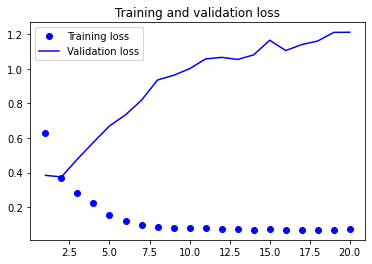

In [ ]:
def draw_graph(history):
  import matplotlib.pyplot as plt
  loss = history['loss']
  val_loss = history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

draw_graph(history)

In [ ]:
mse, mae = model.evaluate(x_test, y_test, verbose=1)

mae

782/782 [==============================] - 3s 4ms/step - loss: 1.3351 - accuracy: 0.8626


0.862559974193573

Одномерные сверточные нейронные сети не чувствительный к порядке следования токенов. Это эффективно в тексте. Но, например, при предсказании температуры - крайне неэффективно, так как там порядок имеет важнейшую роль.

Пример предсказание температуры с помощью одномерных сверточных нейронный сетей

In [ ]:
# все данные идентичны ноутбуку RNN_jena

import pandas as pd
import numpy as np

data_path = '/content/drive/My Drive/StudyingKeras/RNN/jena_climate_data_2009_20016/jena_climate_2009_2016.csv'

# Этот код выведет 420 551 строку с данными - каждая строка соответствует
# одному замеру и содержит дату замера и 14 значений разных параметров
data = pd.read_csv(data_path)


with open(data_path, 'r') as f:
  data = f.read()

# получение всех строк 
lines = data.split('\n')
# получение заголовков всех столбцов
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  # каждое значение в строке отделено запятой
  values = [float(x) for x in line.split(',')[1:]]
  # все переведенные в float числа помещает в массив
  float_data[i, :] = values

# все данные измеряются в разных диапозонах (температура, давление...)
# поэтому нормализуем их
mean = float_data[:200_000].mean(axis=0)
float_data -= mean
std = float_data[:200_000].std(axis=0)
float_data /= std

# принимает: текущий массив данных
# возвращает: пакеты, представляющие собой недавнее прошлое, предсказанную температуру
# data - нормализованные данные
# lookback - количество интервалов из прошлого
# delay - количество интервалов из будущего
# min_index, max_index - границы в data, в которых выбираются значения
# shuffle - извлекать по порядку или с перемешиванием
# batch_size - количество образцов в пакете
# step - период в интервалах, в котором выбираются значения (6 - значит каждый час)

def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
  # если правая граница не указана - она определяется сама
  if max_index is None:
    max_index = len(data) - delay - 1
  # правая граница первого интервала
  i = min_index + lookback
  while True:
    if shuffle:
      # если данные не извлекаются по порядку, то генерируем список случайных
      # строк, откуда эти данные будем брать
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size > max_index:
        # если дошли до конца (до самой правой границы), то возвращаемся в начало
        i = min_index + lookback
      # генерируем список подряд идущиъ индексов строк
      rows = np.arange(i, min(i + batch_size, max_index))
      # смещаем правую границу первого интервала к концу только что созданного списка
      # так как мы его будем обрабатывать и больше его начало нас не интересует
      i += len(rows)
    # создаем тензоры образцов и целей
    # все это - просто часть известных данных из файла
    # samples - данные из прошлого
    # targets - данные (как бы) из будущего (просто правее)
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      # берем lookback значений из прошлого с интервалом step
      indices = range(rows[j] - lookback, rows[j], step)
      # извлекаем образцы из прошлого по индексам
      samples[j] = data[indices]
      # извлекаем цели (которые тоже образцы) из будущего
      targets[j] = data[rows[j] + delay][1]
    # образцы возвращаются в прямом порядке
    # для большинства временных последовательностей если сеть обрабатывает последовательность в прямом порядке
    # то она лучше обучается, чем если в обратном
    yield samples, targets    

# 10 дней назад
lookback = 1440
# замеры раз в час
step = 6
# вперед на день
delay = 144
batch_size = 128

train_generator = generator(
    float_data, 
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200_000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)

val_generator = generator(
    float_data, 
    lookback=lookback,
    delay=delay,
    min_index=200_001,
    max_index=300_000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)

test_generator = generator(
    float_data, 
    lookback=lookback,
    delay=delay,
    min_index=300_000,
    max_index=None,
    shuffle=True,
    step=step,
    batch_size=batch_size
)

# сколько раз надо обратиться к val_generator, чтобы получить проверочный набор целиком
val_steps = (300_000 - 200_001 - lookback) // batch_size
# сколько раз надо обратиться к test_generator, чтобы получить тестовый набор целиком
test_steps = (len(float_data) - 300_001 - lookback) // batch_size

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D

model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mae')

history = model.fit(
    train_generator,
    steps_per_epoch=500,
    epochs=20,
    validation_data = val_generator,
    validation_steps = val_steps
).history


Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4090 - val_loss: 0.4323
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3568 - val_loss: 0.4467
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3354 - val_loss: 0.4563
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3226 - val_loss: 0.4522
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3109 - val_loss: 0.4339
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3034 - val_loss: 0.4433
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2961 - val_loss: 0.4463
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2906 - val_loss: 0.4447
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2844 - val_loss: 0.4414
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.279

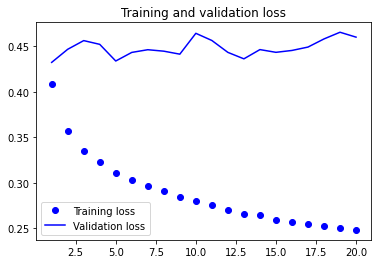

In [ ]:
def draw_graph(history):
  import matplotlib.pyplot as plt
  loss = history['loss']
  val_loss = history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

draw_graph(history)

Как мы видим, ошибка слишком большая.

Это значит, что ОСС плохо справляется с временными последовательностями